# Bayesian Networks
## Thinking about causality in ML

Let's try import everything we're going to need... 
Use the cell after if needs be to do the installs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from IPython.display import Markdown, display

from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

def printmd(string):
    display(Markdown(string))

In [2]:
# # Only use these if missing packages
# !pip install -r requirements.txt
# # Install pygraphviz separately if on anaconda and pip fails
# !conda install pygraphviz

In [3]:
# # Can turn off plotting warnings once seen/understand ensuring NOTEARs converges
# import warnings
# warnings.filterwarnings("ignore")

## Part I: Setting up and structure learning

We will use the [Adult Data Set](http://archive.ics.uci.edu/ml/datasets/Adult) published in the UCI Machine Learning Repository (Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.)

##### We're going to try understand what are the **drivers** of **income**.


In [4]:
# Load data
columns = ["age", "workclass", "fnlwgt", "education", "education_num", 
           "marital_status", "occupation", "relationship", "race",  "sex", 
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

data = pd.read_csv('adult.data', names=columns, sep=', ', engine='python')
data = data.drop(columns=["fnlwgt", "education_num", "race", "sex"])

data.head()

,age,workclass,education,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,0,0,40,Cuba,<=50K


In [5]:
# Mini profiling of the data
for col in data.columns:
    printmd(f"**{col}**:")
    if data[col].dtype == 'object':
        print(data[col].value_counts())
    else:
        print(data[col].describe())

**age**:

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


**workclass**:

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


**education**:

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


**marital_status**:

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64


**occupation**:

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


**relationship**:

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


**capital_gain**:

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64


**capital_loss**:

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64


**hours_per_week**:

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64


**native_country**:

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

**income**:

<=50K    24720
>50K      7841
Name: income, dtype: int64


In [6]:
# Map categorical columns
data_vals = {col: data[col].unique() for col in data.columns}

categorical_maps = {"workclass": {v: 'Gov' if 'gov' in v else 'Private' if 'Private' in v else 'Other' for v in data_vals['workclass']},
                    "education": {v: 'Further' if v in ['Assoc-acdm', 'Assoc-voc', 'Some-college', 'Prof-school']
                                      else 'Degree' if v in ['Bachelors', 'Masters', 'Doctorate']   
                                      else 'HS' for v in data_vals['education']},
                    "marital_status": {v: 'Married' if v in ['Married-civ-spouse']
                                       else 'Never Married' if v in ['Never-married']
                                     else 'Other' for v in data_vals["marital_status"]},
                    "occupation": {v: 'Blue-Collar' if v in ['Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 
                                                             'Machine-op-inspct', 'Transport-moving']
                                     else 'Professional' if v in ['Sales', 'Prof-specialty'] 
                                     else 'Exec' if v in ['Exec-managerial'] 
                                     else 'Other' for v in data_vals["occupation"]},
                    "relationship": {v: 'Other' if v not in ['Husband', 'Wife'] else 'Married' for v in data_vals["relationship"]},
                    "native_country": {v: 'United States' if v == 'United-States' else 'Other' for v in data_vals["native_country"]}
                   }

for col in categorical_maps.keys():
    data[col] = data[col].map(categorical_maps[col])

In [7]:
# Re-profile categorical data
for col in data.columns:
    if data[col].dtype == 'object':
        printmd(f"**{col}**:")
        print(data[col].value_counts())


**workclass**:

Private    22696
Other       5514
Gov         4351
Name: workclass, dtype: int64


**education**:

HS         14754
Further    10316
Degree      7491
Name: education, dtype: int64


**marital_status**:

Married          14976
Never Married    10683
Other             6902
Name: marital_status, dtype: int64


**occupation**:

Other           10643
Blue-Collar     10062
Professional     7790
Exec             4066
Name: occupation, dtype: int64


**relationship**:

Other      17800
Married    14761
Name: relationship, dtype: int64


**native_country**:

United States    29170
Other             3391
Name: native_country, dtype: int64


**income**:

<=50K    24720
>50K      7841
Name: income, dtype: int64


In [8]:
# Label encode categorical variables for structure learning algorithm

struct_data = data.copy()

le = LabelEncoder()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,age,workclass,education,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,0,0,1,2,1,2174,0,40,1,0
1,50,1,0,0,1,0,0,0,13,1,0
2,38,2,2,2,0,1,0,0,40,1,0
3,53,2,2,0,0,0,0,0,40,1,0
4,28,2,0,0,3,0,0,0,40,0,0


/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/causalnex/structure/notears.py:411: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/causalnex/structure/notears.py:395: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/causalnex/structure/notears.py:411: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/causalnex/structure/notears.py:440: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pygraphvi

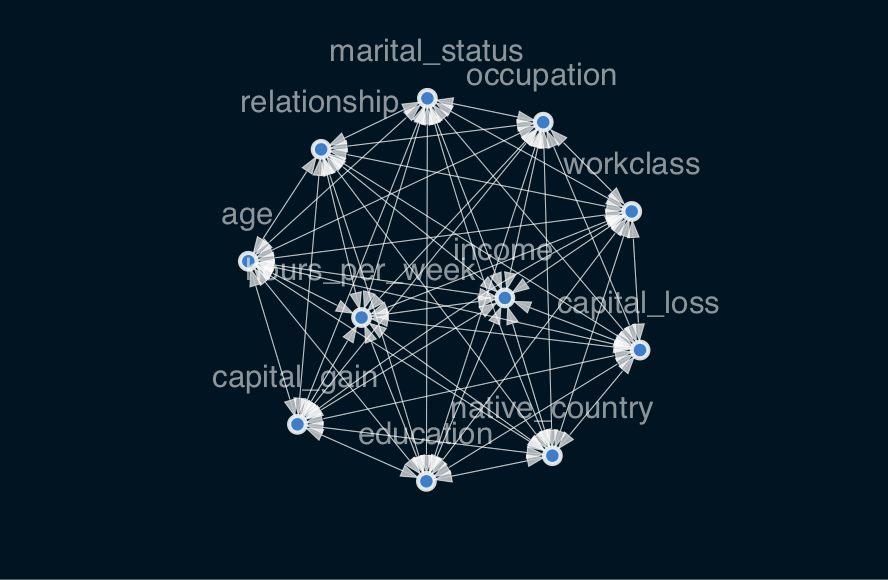

In [9]:
# Try run the NOTEARs structure learning algorithm on the data
sm = from_pandas(struct_data)

# Plot the graph
viz = plot_structure(sm, graph_attributes={"scale": "0.95"}, all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

**Multiple issues here:** 

1) Structure learning doesn't converge and 

2) Even if it did - there are far too many edges; we haven't set a threshold on what's an "important" edge to make for the NOTEARS algorithm

**Hypothesis**: distribution of numerical variables is causing non-convergence. Try discretise these too?

In [10]:
# Try discretise numerical columns
# Tuple[1] mapping is for use later, not relevant for now...

discretise_maps = {"age": ([30, 45], ["Young", "Middle", "Old"]),
                  "hours_per_week": ([40, 45], ["Below Average", "Average", "Highest"]),
                  "capital_gain": ([1], ["None", "Some"]),
                  "capital_loss": ([1], ["None", "Some"])}

for col in discretise_maps.keys():
    struct_data[col] = Discretiser(method="fixed", numeric_split_points=discretise_maps[col][0]).transform(struct_data[col].values)
    

In [11]:
# Re-profile categorical data
for col in struct_data.columns:
    printmd(f"**{col}**:")
    print(struct_data[col].value_counts())

**age**:

1    12489
2    10361
0     9711
Name: age, dtype: int64


**workclass**:

2    22696
1     5514
0     4351
Name: workclass, dtype: int64


**education**:

2    14754
1    10316
0     7491
Name: education, dtype: int64


**marital_status**:

0    14976
1    10683
2     6902
Name: marital_status, dtype: int64


**occupation**:

2    10643
0    10062
3     7790
1     4066
Name: occupation, dtype: int64


**relationship**:

1    17800
0    14761
Name: relationship, dtype: int64


**capital_gain**:

0    29849
1     2712
Name: capital_gain, dtype: int64


**capital_loss**:

0    31042
1     1519
Name: capital_loss, dtype: int64


**hours_per_week**:

1    15835
2     8963
0     7763
Name: hours_per_week, dtype: int64


**native_country**:

1    29170
0     3391
Name: native_country, dtype: int64


**income**:

0    24720
1     7841
Name: income, dtype: int64


In [12]:
# Try structure learning on the new data
sm = from_pandas(struct_data)

Algorithm now converges.... try a threshold on the edges and plot...

/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


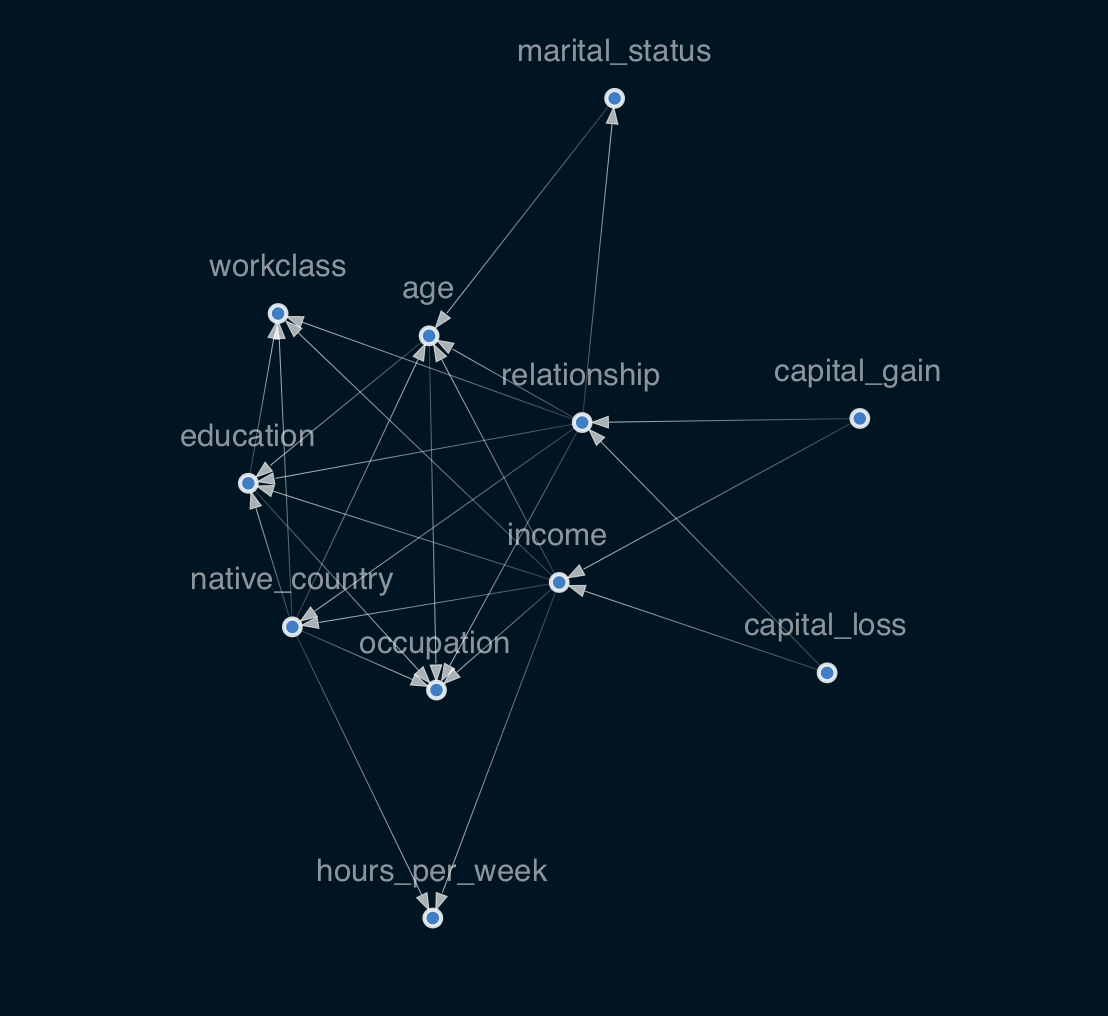

In [13]:
# Remove edges that dont have a significant importance
sm.remove_edges_below_threshold(0.25)

viz = plot_structure(sm, graph_attributes={"scale": "0.95"}, 
                     all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [14]:
# Flip edges that don't make causal sense
to_flip = [('marital_status', 'age'), 
           ('relationship', 'age'),
           ('relationship', 'native_country'),
           ('income', 'age'),
           ('income', 'workclass'),
           ('income', 'education'),
           ('income', 'occupation'),
           ('income', 'hours_per_week'),
           ('income', 'native_country')]

sm.remove_edges_from(to_flip)

for ed in to_flip:
    try:
        sm.add_edge(ed[1], ed[0])
    except:
        print(f"{ed} not possible")


/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


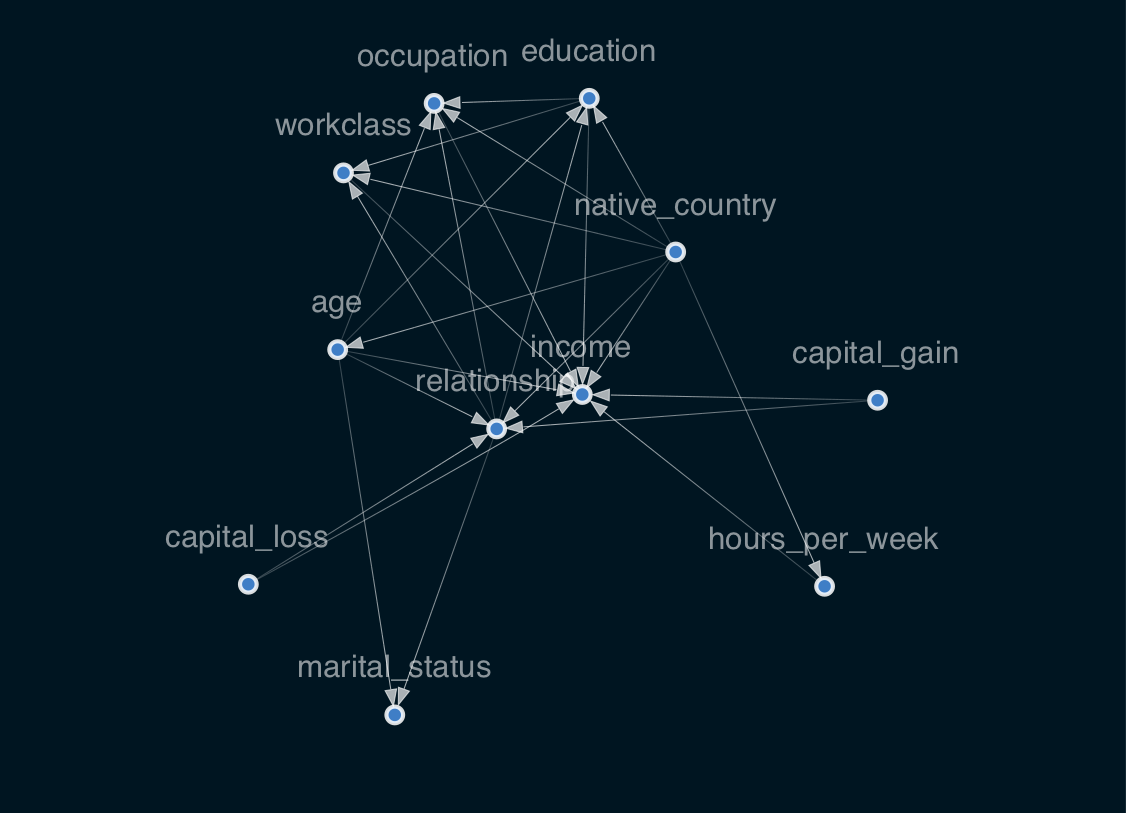

In [15]:
viz = plot_structure(sm, graph_attributes={"scale": "0.95"}, all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

If we still don't like the graph, we can contimue to manually adjust using expert input, or adjust the algorithm to ignore certain edges when learning

In [16]:
## Add edges
# sm.add_edge("age", "marital_status")

## Remove edges
# sm.remove_edge("native_country", "age")

## Enforce a 'tabu' list that blocks the creation of certain edges in structure learning itself
# sm = from_pandas(struct_data, tabu_edges=[("race", "sex")], w_threshold=0.3)

This will be a highly iterative process... some other considerations:

* Are there better solutions to get the algorithm to converge other than discretisation?
* Do we need to change the direction of any edges to make causal sense?
* Are there sensitive attributes that should be removed?


Select a final graph. One final thing to check is if there are any isolated nodes, we need to remove them...

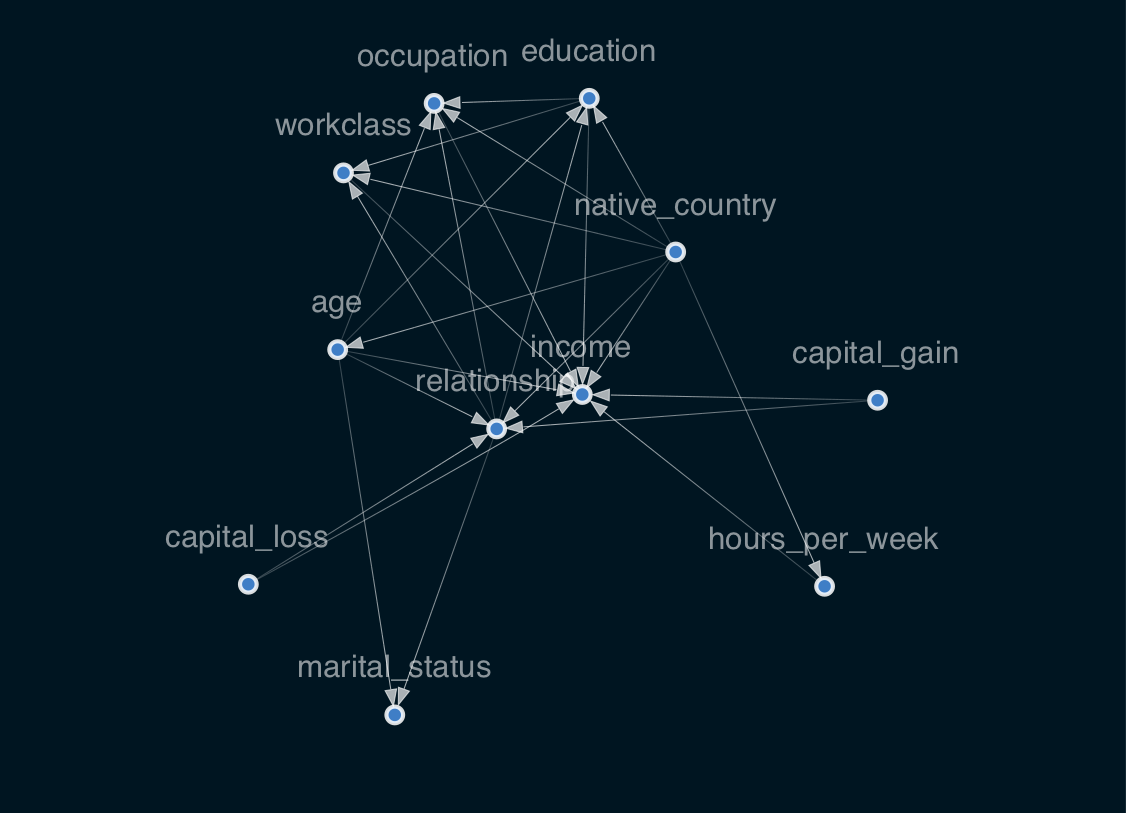

In [17]:
# Handle isolated nodes
sm = sm.get_largest_subgraph()

# Plot final structure
viz = plot_structure(sm, graph_attributes={"scale": "0.95"}, all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

*Questions!*

Let's explore the sensitivity of the structure learned to:
- the discretisation
- the parameters of the NOTEARS algorithm

Can you explore different configurations and find different results? How do we validate our results anyway? Can you set this up as a "parameter tuning" problem?

## Part II: Finalising discretisation and probability fitting

Let's convert to a BN object and fit the CPD tables

In [18]:
# Convert the structure object into a Bayesian Network
bn = BayesianNetwork(sm)

In [19]:
# For fitting CPDs we want to keep the categories for easier labelling (i.e. not the label encoded data)
discretised_data = data.copy()

# We can also add labels to the discretised continuous variables
for col in discretise_maps.keys():
    discretised_data[col] = Discretiser(method="fixed", numeric_split_points=discretise_maps[col][0]).transform(discretised_data[col].values)
    # Map on to the label defined above
    discretised_data[col] = discretised_data[col].map(dict(zip(sorted(discretised_data[col].unique()), discretise_maps[col][1])))

discretised_data.head()

,age,workclass,education,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,native_country,income
0,Middle,Gov,Degree,Never Married,Other,Other,Some,None,Average,United States,<=50K
1,Old,Other,Degree,Married,Exec,Married,None,None,Below Average,United States,<=50K
2,Middle,Private,HS,Other,Blue-Collar,Other,None,None,Average,United States,<=50K
3,Old,Private,HS,Married,Blue-Collar,Married,None,None,Average,United States,<=50K
4,Young,Private,Degree,Married,Professional,Married,None,None,Average,Other,<=50K


In [20]:
# Split into a train/test set so we can validate our model
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=5)

In [21]:
# Just in case the train doesn't have all states in the test data, tell the CPDs the 'full universe' of states from the full data...
bn = bn.fit_node_states(discretised_data)

In [22]:
# ...then fit just the train data to estimate the probabilities
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} pri

In [23]:
# Assess the performance of the 'target' node (i.e. "income")
pd.DataFrame(classification_report(bn, test, "income"))

,income_<=50K,income_>50K,accuracy,macro avg,weighted avg
precision,0.831368,0.670306,0.80872,0.750837,0.792846
recall,0.939064,0.394095,0.80872,0.666579,0.808720
f1-score,0.881940,0.496362,0.80872,0.689151,0.789719
support,2478.000000,779.000000,0.80872,3257.000000,3257.000000


In [24]:
# Assess the performance by ROC AUC
roc, auc = roc_auc(bn, test, "income")
print(auc)

0.8911109384958534


*Questions!*

How can we improve the performance?
What happens when we don't have enough data to cover all options? When will this get worse? How can we try/help solve for this?

## Part III: Inference & interventions
Finally, we can query the graphs with "observations" and "interventions"

In [25]:
# Fit all the data to the CPDs, not just the train data
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/paul_beaumont/opt/anaconda3/envs/py36/lib/python3.6/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} pri

In [26]:
ie = InferenceEngine(bn)
marginals = ie.query()

In [27]:
# What are the "base" marginals, without any observations/interventions?
for marginal in marginals:
    printmd(f"**{marginal}**")
    print({k: np.round(v, 3) for k, v in marginals[marginal].items()})

**age**

{'Middle': 0.384, 'Old': 0.318, 'Young': 0.298}


**education**

{'Degree': 0.23, 'Further': 0.317, 'HS': 0.453}


**occupation**

{'Blue-Collar': 0.309, 'Exec': 0.125, 'Other': 0.327, 'Professional': 0.239}


**marital_status**

{'Married': 0.459, 'Never Married': 0.327, 'Other': 0.215}


**relationship**

{'Married': 0.452, 'Other': 0.548}


**income**

{'<=50K': 0.755, '>50K': 0.245}


**workclass**

{'Gov': 0.134, 'Other': 0.169, 'Private': 0.697}


**capital_gain**

{'None': 0.917, 'Some': 0.083}


**capital_loss**

{'None': 0.953, 'Some': 0.047}


**hours_per_week**

{'Average': 0.486, 'Below Average': 0.238, 'Highest': 0.275}


**native_country**

{'Other': 0.104, 'United States': 0.896}


In [28]:
# What are the marginals after we "observe" that P(occupation = Professional) ?
query_marginals = ie.query(observations={'occupation':'Professional'})
for marginal in query_marginals:
    printmd(f"**{marginal}**")
    print({k: np.round(v, 3) for k, v in query_marginals[marginal].items()})

**age**

{'Middle': 0.4, 'Old': 0.327, 'Young': 0.273}


**education**

{'Degree': 0.463, 'Further': 0.317, 'HS': 0.221}


**occupation**

{'Blue-Collar': 0.0, 'Exec': 0.0, 'Other': 0.0, 'Professional': 1.0}


**marital_status**

{'Married': 0.485, 'Never Married': 0.307, 'Other': 0.207}


**relationship**

{'Married': 0.479, 'Other': 0.521}


**income**

{'<=50K': 0.649, '>50K': 0.351}


**workclass**

{'Gov': 0.166, 'Other': 0.167, 'Private': 0.666}


**capital_gain**

{'None': 0.916, 'Some': 0.084}


**capital_loss**

{'None': 0.953, 'Some': 0.047}


**hours_per_week**

{'Average': 0.486, 'Below Average': 0.239, 'Highest': 0.276}


**native_country**

{'Other': 0.094, 'United States': 0.906}


In [29]:
# What are the marginals after we "intervene" that P(do(relationship = "Married")) ?
printmd(f"Income pre marital intervention: "+ str({k: np.round(v, 3) for k,v in ie.query(observations={'age':'Young', 'marital_status': 'Never Married'})['income'].items()}))

# Note how can't act on "marital_status" 
ie.do_intervention('relationship',{'Married': 1, 'Other': 0})
printmd(f"Income post marital intervention: "+ str({k: np.round(v, 3) for k,v in ie.query(observations={'age':'Young'})['income'].items()}))
ie.reset_do("relationship")


Income pre marital intervention: {'<=50K': 0.902, '>50K': 0.098}

Income post marital intervention: {'<=50K': 0.88, '>50K': 0.12}

*Questions!*

Can you think of how we might find the "optimal" intervention to make?